In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip3 install pydicom
!pip install split-folders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 35.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import pydicom as dicom
import os
import cv2
import PIL
from PIL import Image

class Main:
  def __init__(self, dcm, png):
    self.dcm=dcm
    self.png=png
  #conversion from dicom to png for one stage
  def dcm_to_png(self):
    print(self.dcm)
    datapath=self.dcm
    l=sorted(glob.glob(datapath + '*/*/*/*'))
    for i in range(1, len(l)): 
        folder_path = l[i]
      # Specify the output jpg/png folder path
        PNG=True
        png_folder_path = self.png
        images_path = os.listdir(folder_path)
        try:
          for n, image in enumerate(images_path):
              ds = dicom.dcmread(os.path.join(folder_path, image), force=True)
              ds.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian 
              pixel_array_numpy = ds.pixel_array
              if PNG == False:
                  image = image.replace('.dcm', '.png')
              else:
                  image = image.replace('.dcm', '.png')
              cv2.imwrite(os.path.join(png_folder_path, image), pixel_array_numpy)
              if n % 50 == 0:
                  print('{} image converted'.format(n))
        except ValueError:
            continue
        except AttributeError:
            continue
  def resizing(self):
    dataset1=os.listdir(self.png)
    for i in dataset1:
      filepath=os.path.join(self.png, i)
      try:
        image=cv2.imread(filepath)
        output=cv2.resize(image, (128,128))
        cv2.imwrite(os.path.join(filepath),output)
      except:
        print("exception in the filepath", filepath)

  def gray_scale_conversion(self):
    from skimage import io
    folder_path=self.png
    images_path=os.listdir(folder_path)
    for i,image in enumerate(images_path):
      image = io.imread(os.path.join(folder_path+'/'+image), as_gray=True)
      print(image.shape) 

  def count(self):
    count=os.listdir(self.png)
    print(len(count))

In [ ]:
preprocessing=Main("/content/drive/MyDrive/demo TCGA/all_stages/stage1", "/content/drive/MyDrive/demo TCGA/png_folder/stage1")
preprocessing.dcm_to_png()
preprocessing.resizing()
preprocessing.gray_scale_conversion()
preprocessing.count()

In [ ]:
preprocessing=Main("/content/drive/MyDrive/demo TCGA/all_stages/stage 2", "/content/drive/MyDrive/demo TCGA/png_folder/stage2")
#preprocessing.dcm_to_png()
#preprocessing.resizing()
#preprocessing.gray_scale_conversion()
preprocessing.count()

79


In [ ]:
preprocessing=Main("/content/drive/MyDrive/demo TCGA/all_stages/stage 3", "/content/drive/MyDrive/demo TCGA/png_folder/stage3")
preprocessing.dcm_to_png()
preprocessing.resizing()
preprocessing.gray_scale_conversion()
preprocessing.count()

/content/drive/MyDrive/demo TCGA/all_stages/stage 3
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
100 image converted
0 image converted
0 image converted
50 image converted
100 image converted
0 image converted
0 image converted
0 image converted
50 image converted
100 image converted
0 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
0 image converted
50 image converted
100 image converted
150 image converted
0 image converted
0 image converted
50 image converted
0 image converted
0 image converted
0 image converted
50 image converted
0 image converted
50 image converted
100 image converted
0 image converted
50 image converted
100 image converted
150 image conver

In [ ]:
class Model:
  global train_generator, test_datagen, valid_generator
  def __init__(self, all_png):
    self.all_png=all_png

  def split(self):
    import splitfolders
    splitfolders.ratio(self.all_png, output="split", seed=1, ratio=(.7, .15, .15), group_prefix=None)

  def image_data_generator(self):
    from keras.preprocessing.image import ImageDataGenerator
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            zoom_range=0.2,
            horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale = 1./255)
    train_generator = train_datagen.flow_from_directory(self.all_png,
    target_size=(128, 128),
            batch_size=32,
            class_mode='categorical',
            color_mode="grayscale")
    valid_generator = test_datagen.flow_from_directory(self.all_png,
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical',
            color_mode="grayscale")
    print(train_generator, test_datagen, valid_generator)

    from keras.models import Sequential
    #from keras.layers.normalization import Batch Normalization
    from keras.layers import Dense, Conv2D,Conv3D, MaxPooling2D, Flatten, Dropout
    model=Sequential()
    input_shape=(128,128,1)
    model.add(Conv2D(16, kernel_size=(3,3), input_shape=input_shape,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, kernel_size=(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, kernel_size=(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, kernel_size=(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit_generator(train_generator,  validation_data = valid_generator, epochs=30, verbose=1)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/BBIN_TCIA+/Dataset /TCGA/all_stages',target_size=(128, 128),batch_size=32,class_mode='categorical',color_mode="grayscale") 
    loss_and_metrics = model.evaluate(test_generator, batch_size=128)
    print("Accuracy in the test datatset is {}".format(loss_and_metrics))

    from matplotlib import pyplot
    pyplot.subplot(211)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='validation')
    pyplot.legend()
    pyplot.show()

Copying files: 830 files [00:01, 514.61 files/s]
<ipython-input-54-76d4bde39dac>:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,  validation_data = valid_generator, epochs=30, verbose=1)


Found 830 images belonging to 3 classes.
Found 830 images belonging to 3 classes.
<keras.preprocessing.image.DirectoryIterator object at 0x7f4cb2657d60> <keras.preprocessing.image.ImageDataGenerator object at 0x7f4cb2616970> <keras.preprocessing.image.DirectoryIterator object at 0x7f4cb3ee4ac0>
Epoch 1/30
26/26 [==============================] - 14s 182ms/step - loss: 0.8554 - accuracy: 0.6904 - val_loss: 0.7665 - val_accuracy: 0.7108
Epoch 2/30
26/26 [==============================] - 4s 173ms/step - loss: 0.5701 - accuracy: 0.8096 - val_loss: 0.4146 - val_accuracy: 0.8759
Epoch 3/30
26/26 [==============================] - 4s 173ms/step - loss: 0.4301 - accuracy: 0.8506 - val_loss: 0.3461 - val_accuracy: 0.8867
Epoch 4/30
26/26 [==============================] - 4s 171ms/step - loss: 0.4011 - accuracy: 0.8386 - val_loss: 0.3017 - val_accuracy: 0.9157
Epoch 5/30
26/26 [==============================] - 4s 168ms/step - loss: 0.3701 - accuracy: 0.8373 - val_loss: 0.2446 - val_accuracy: 

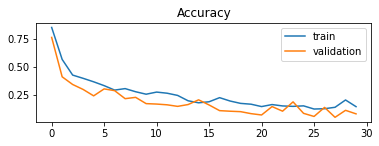

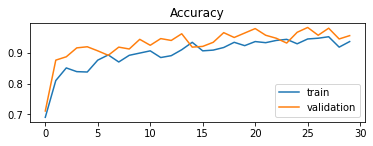

In [ ]:
run_model=Model("/content/drive/MyDrive/demo TCGA/png_folder")
run_model.split()
run_model.image_data_generator()

In [ ]:
#mapping clinical and patient dataset
import pandas as pd

In [ ]:
data=pd.read_excel("/content/drive/MyDrive/demo TCGA/brca-clinicalforwiki (2).xls")

In [ ]:
data.head()

,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,ajcc_cancer_metastasis_stage_code,ajcc_neoplasm_disease_lymph_node_stage,ajcc_neoplasm_disease_stage,ajcc_tumor_stage_code,anatomic_organ_subdivision,axillary_lymph_node_stage_method_type,breast_cancer_optical_measurement_histologic_type,breast_cancer_surgery_margin_status,...,lymph_node_examined_count,margin_status,menopause_status,number_of_lymphnodes_positive_by_he,patient_id,pretreatment_history,prior_diagnosis,race,tissue_source_site,vital_status
0,TCGA-E2-A107,54,M0,N2a,Stage IIIA,T3,Right Upper Inner Quadrant,Sentinel lymph node biopsy plus axillary disse...,Infiltrating Lobular,[Not Available],...,27,Negative,Post (prior bilateral ovariectomy OR >12 mo si...,4,A107,NO,NO,WHITE,E2,LIVING
1,TCGA-E2-A108,64,M0,N2a,Stage IIIA,T2,Right Upper Outer Quadrant,[Not Available],Infiltrating Ductal,[Not Available],...,27,Negative,Post (prior bilateral ovariectomy OR >12 mo si...,4,A108,NO,NO,WHITE,E2,LIVING
2,TCGA-E2-A109,64,M0,N0 (i-),Stage IIA,T2,Right Upper Outer Quadrant,Sentinel node biopsy alone,Infiltrating Ductal,[Not Available],...,6,Negative,Post (prior bilateral ovariectomy OR >12 mo si...,0,A109,NO,NO,WHITE,E2,LIVING
3,TCGA-E2-A10B,67,M0,N1a,Stage IIB,T2,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Infiltrating Ductal,[Not Available],...,28,Close,Post (prior bilateral ovariectomy OR >12 mo si...,2,A10B,NO,NO,WHITE,E2,LIVING
4,TCGA-E2-A10C,54,M0,N1a,Stage IIB,T2,Left Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Infiltrating Ductal,[Not Available],...,13,Negative,Post (prior bilateral ovariectomy OR >12 mo si...,1,A10C,NO,NO,WHITE,E2,LIVING


In [ ]:
df = data[['bcr_patient_barcode','ajcc_neoplasm_disease_stage']]

In [ ]:
df

,bcr_patient_barcode,ajcc_neoplasm_disease_stage
0,TCGA-E2-A107,Stage IIIA
1,TCGA-E2-A108,Stage IIIA
2,TCGA-E2-A109,Stage IIA
3,TCGA-E2-A10B,Stage IIB
4,TCGA-E2-A10C,Stage IIB
...,...,...
329,TCGA-AO-A0JF,Stage IIA
330,TCGA-AO-A0JJ,Stage IIB
331,TCGA-AO-A0JL,Stage IIIA
332,TCGA-AO-A0JM,Stage IIB


In [ ]:
import re